# Öneri Sistemleri

Öneri sistemleri, kullanıcıların geçmiş tercihlerine dayanarak onlara ürünler önermek için kullanılır. Öneri sistemleri genel olarak aşağıdaki kategorilere ayrılır:

- **İçerik tabanlı (Content-based)**: Ürün özelliklerinin (ör. anahtar kelimeler, kategoriler) ve kullanıcı tercihlerinin benzerliğine dayanır.  
  Örneğin, bir kullanıcı Ürün A’yı beğendiyse, öneri sistemi benzer özelliklere sahip ürünleri önerir. Filmler üzerinden konuşursak, bu özellikler yapımcı, tür vb. olabilir. Genellikle bu yaklaşım, denetimli bir ikili sınıflandırma algoritması ile uygulanabilir.

- **İşbirlikçi filtreleme (Collaborative filtering)**: Benzerliği kullanıcı–ürün etkileşimlerinden (ör. puanlar, satın alma sayısı, beğeniler vb.) hesaplar.  
  Bu yöntem, benzer tercihlere sahip müşterileri bulur ve ardından bir müşteriye, onun henüz deneyimlemediği fakat benzer profildeki diğer müşteriler tarafından tercih edilen ürünleri önerir. Sistem, benzer film izleme alışkanlıklarına sahip kullanıcıların genel olarak benzer tercihlere sahip olduğu varsayımını yapar. Kullanıcının izlediklerine benzer videolar izleyen diğer kullanıcıları bulur, ardından bu kullanıcıların izlediği fakat ilk kullanıcının henüz izlemediği videoları önerir. Bu yaklaşımın 3 türü vardır: kullanıcı–kullanıcı işbirlikçi filtreleme, ürün–ürün işbirlikçi filtreleme ve matris çarpanlarına ayırma (matrix factorization).

- Daha yeni ve genellikle daha güçlü yaklaşımlar ise **Hibrit sistemlerdir (Hybrid systems)**.  
  Bu sistemler, yukarıda bahsedilen iki yöntemi birleştirir.

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/06-Unsupervised-Learning/recommendation_systems.png" width=600>

Yukarıdaki diyagram, bir öneri sistemi oluşturmak için kullanılan farklı metodolojileri detaylı bir şekilde sınıflandırmaktadır.

Daha sonra örnek veri seti olarak kullanılacak olan `movieLens` bağlamında:
- İçerik benzerliğine (ör. tür, oyuncu kadrosu vb.) dayalı olarak farklı filmler önerebiliriz; bu durumda **ürün-içerik (item-content) filtreleme** uygulanır.
- Kullanıcı meta verilerini (ör. yaş, cinsiyet) karşılaştırarak, benzer kullanıcıların beğendiği ürünleri bir kullanıcıya önerebiliriz; bu durumda **kullanıcı-içerik (user-content) filtreleme** kullanılır. Ancak `movieLens` veri seti kullanıcı içerik verilerini içermediği için, yalnızca **ürün-ürün (item-item) işbirlikçi filtreleme** oluşturacağız.

**Bellek tabanlı (Memory-based) içerik filtreleme**

Bellek tabanlı yöntemlerde, veriden öğrenip tahmin yapan bir model yoktur. Bunun yerine, film önerileri için kullanılabilecek **önceden hesaplanmış bir benzerlik matrisi** oluşturulur.

## Veri toplama ve temizleme

Aşağıdaki satırları çalıştırarak gerekli veri kümelerini indirin. Ardından, veri kümelerini üç farklı pandas DataFrame'e (`movies`, `tags` ve `ratings`) yükleyin.

In [31]:
!curl https://d32aokrjazspmn.cloudfront.net/materials/movie_ratings.csv > data/movies.csv
!curl https://d32aokrjazspmn.cloudfront.net/materials/movie_tags.csv > data/tags.csv
!curl https://d32aokrjazspmn.cloudfront.net/materials/movie_titles.csv > data/ratings.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2425k  100 2425k    0     0  1683k      0  0:00:01  0:00:01 --:--:-- 1684k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  115k  100  115k    0     0   443k      0 --:--:-- --:--:-- --:--:--  443k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  482k  100  482k    0     0  1038k      0 --:--:-- --:--:-- --:--:-- 1038k


In [32]:
# Veri kümelerini üç farklı pandas DataFrame'e (`movies`, `tags` ve `ratings`) yüklüyoruz.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

movies = pd.read_csv('data/movies.csv')
tags = pd.read_csv('data/tags.csv')
ratings = pd.read_csv('data/ratings.csv')

display(movies.head())
display(tags.head())
display(ratings.head())


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


__Farklı film türlerini ayıran ‘|’ işaretini kaldırın ve boşluk ile değiştirin.__

In [33]:
movies.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [34]:
print("movies shape:", movies.shape)
print("movies columns:", movies.columns.tolist())
display(movies.head())

movies shape: (100836, 4)
movies columns: ['userId', 'movieId', 'rating', 'timestamp']


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [35]:
ratings['genres'] = ratings['genres'].str.replace('|', ' ', regex=False)

ratings[['title', 'genres']].head()

,title,genres
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,Jumanji (1995),Adventure Children Fantasy
2,Grumpier Old Men (1995),Comedy Romance
3,Waiting to Exhale (1995),Comedy Drama Romance
4,Father of the Bride Part II (1995),Comedy


__`movies` veri çerçevesini filtreleyerek, yalnızca puan almış filmleri elde edin.__

In [36]:
movies.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [37]:
# movies içinde sadece ratings içindeki movieId yi tutacağız.
movies = movies[movies.movieId.isin(ratings.movieId.unique())]

print("Yeni movies boyutu:", movies.shape)

Yeni movies boyutu: (100836, 4)


In [40]:
import pandas as pd

# 1. Dosyaları DOĞRU isimlerle tekrar indiriyoruz/okuyoruz
# Dikkat: movie_titles -> movies.csv olmalı (İçinde genres var)
# movie_ratings -> ratings.csv olmalı

# Pandas ile direkt URL'den de okuyabiliriz, bu daha garanti olur:
movies = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/movie_titles.csv")
tags = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/movie_tags.csv")
ratings = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/movie_ratings.csv")

# 2. Farklı film türlerini ayıran '|' işaretini kaldırın ve boşluk ile değiştirin.
# Artık movies içinde 'genres' sütunu olduğu için bu kod çalışacak.
movies['genres'] = movies['genres'].str.replace('|', ' ')

# 3. movies veri çerçevesini filtreleyerek, yalnızca puan almış filmleri elde edin.
movies = movies[movies['movieId'].isin(ratings['movieId'])]

# Kontrol edelim
print("Movies Sütunları:", movies.columns)
print("-" * 30)
print(movies.head())

Movies Sütunları: Index(['movieId', 'title', 'genres'], dtype='object')
------------------------------
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure Animation Children Comedy Fantasy  
1                   Adventure Children Fantasy  
2                               Comedy Romance  
3                         Comedy Drama Romance  
4                                       Comedy  


### 🧪 Kodunu Test Et

In [41]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'datasets',
    movies_shape=movies.shape,
    tags_shape=tags.shape,
    ratings_shape=ratings.shape,
    genres_cleaned=movies['genres'].str.find('|') >= 0
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/berkayturhan/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/berkayturhan/S17D3-S-data-movie-recommendation/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 4 items

test_datasets.py::TestDatasets::test_genres_are_cleaned PASSED           [ 25%]
test_datasets.py::TestDatasets::test_movies_shape PASSED                 [ 50%]
test_datasets.py::TestDatasets::test_ratings_shape PASSED                [ 75%]
test_datasets.py::TestDatasets::test_tags_shape PASSED                   [100%]

============================== 4 passed in 0.61s ===============================


💯 You can commit your code:

git add tests/datasets.pickle

git commit -m 'Completed datasets step'

git push origin master



## Özellik Mühendisliği

Bir film hakkında sahip olduğumuz **tüm metin verisi bilgilerini**, yani türü ve etiketleri birleştiren `metadata` adlı yeni bir özellik oluşturacağız.

__`movies` ve `tags` DataFrame'lerini birleştirin.__

In [42]:
tags_grouped = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x.dropna())).reset_index()

In [44]:
tags_grouped.head()

,movieId,tag
0,1,pixar pixar fun
1,2,fantasy magic board game Robin Williams game
2,3,moldy old
3,5,pregnancy remake
4,7,remake


**`metadata` sütununu içeren yeni bir `merged_df` veri çerçevesi oluşturun. Bu sütun, hem etiketlerin (tags) hem de türlerin (genres) birleştirilmiş hâlinden oluşmalıdır.**

Bunun için:
- Önce **etiketleri (tags)** film bazında birleştirin.
- Ardından bu birleştirilmiş etiketleri **genres** sütunu ile birleştirin.

Örneğin *Toy Story* filminin `metadata` sütunu şu şekilde olmalıdır:  
`pixar pixar fun Adventure Animation Children Comedy Fantasy`

👉 `merged_df` en azından şu sütunları içermelidir: `movieId`, `title` ve `metadata`.

In [45]:
merged_df = pd.merge(movies, tags_grouped, on='movieId', how='left')

merged_df['tag'] = merged_df['tag'].fillna('')

merged_df['metadata'] = merged_df['genres'] + ' ' + merged_df['tag']

merged_df = merged_df[['movieId', 'title', 'metadata']]

print(merged_df.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                            metadata  
0  Adventure Animation Children Comedy Fantasy pi...  
1  Adventure Children Fantasy fantasy magic board...  
2                           Comedy Romance moldy old  
3                              Comedy Drama Romance   
4                            Comedy pregnancy remake  


### 🧪 Kodunu Test Et

In [46]:
from nbresult import ChallengeResult
import numpy as np

result = ChallengeResult(
    'feature_engineering',
    unique_movies=np.all(merged_df[['movieId']].value_counts() > 1),
    metadata=merged_df[merged_df['title'] == 'Copycat (1995)'],
    merged_df_rows=merged_df.shape[0]
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/berkayturhan/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/berkayturhan/S17D3-S-data-movie-recommendation/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 4 items

test_feature_engineering.py::TestFeatureEngineering::test_merged_df_rows PASSED [ 25%]
test_feature_engineering.py::TestFeatureEngineering::test_metadata_has_genres PASSED [ 50%]
test_feature_engineering.py::TestFeatureEngineering::test_metadata_has_tags PASSED [ 75%]
test_feature_engineering.py::TestFeatureEngineering::test_unicity_of_movies PASSED [100%]

============================== 4 passed in 0.48s ===============================


💯 You can commit your code:

git add tests/feature_engineering.pickle

git commit -m 'Completed feature_engineering step'

git push origin master



## Metadata’dan içerik gizil (latent) matrisi oluşturma

### Count Vectorizer

Bir sonraki adımda, metadata metinlerini vektörlere dönüştürmemiz gerekiyor; böylece bunları makine öğrenmesi algoritmalarına verebiliriz. Makine öğrenmesi modelleri metin verisini doğrudan anlayamaz, bu yüzden kodlamamız gerekir.

Bu amaçla [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) kullanarak `metadata` sütununu encode edeceğiz.

Count dönüşümü sonucunda elde ettiğiniz vektörlerden oluşan yeni bir `count_df` veri çerçevesi oluşturun.  
Her satır, ilgili filme ait **frekans vektörünü** temsil edecektir.

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

count_vectorizer = CountVectorizer(stop_words='english')
count_df = count_vectorizer.fit_transform(merged_df['metadata'])

### Boyut indirgeme

Her bir filmin metadata’sı yaklaşık **1675 uzunluğunda bir vektöre** dönüştürüldü!

Önceki derslerde gördüğümüz gibi, veriyi (filmleri) çok fazla bilgi kaybı olmadan temsil edebilmek için **boyut indirgeme** yöntemleri uygulayabiliriz. **Truncated Singular Value Decomposition (SVD)**, boyut indirgeme için kullanılan başka bir gelişmiş araçtır.

PCA’nın aksine, bu yöntem **tekil değer ayrışımını (SVD) hesaplamadan önce veriyi merkezlemez**. Bu da onun **seyrek (sparse) matrislerle verimli şekilde çalışabilmesini** sağlar. Özellikle terim sayım / frekans matrisleri üzerinde iyi çalışır. Bu bağlamda, **Latent Semantic Analysis (LSA)** olarak da bilinir.

Scikit-Learn’deki [`TruncatedSVD`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) sınıfına göz atabilirsiniz; prensip olarak PCA ile aynıdır.

__👉 **Count matrinizin boyutunu azaltmak için (örneğin 25 feature olacak şekilde) Truncated SVD uygulayın.**__


In [49]:
svd = TruncatedSVD(n_components=25)
latent_matrix = svd.fit_transform(count_df)

👉 **Toplam açıklanan varyans oranını bileşen sayısının bir fonksiyonu olarak grafiğe çizin.**

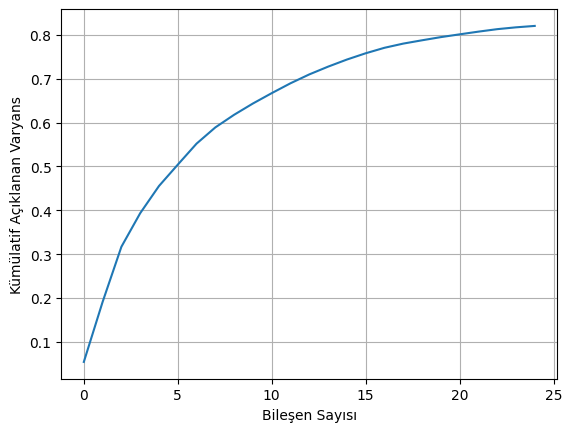

In [50]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Bileşen Sayısı')
plt.ylabel('Kümülatif Açıklanan Varyans')
plt.grid(True)
plt.show()

Sadece ilk 25 bileşenle (başlangıçta yaklaşık 1700 olan) varyansın **%80'inden fazlasını** açıklayabildiğimizi görüyoruz, bu da çalışma amaçlarımız için yeterlidir.

👉 **Bu matrisin 25 bileşenini, filmlerin başlıklarına göre indekslenmiş yeni bir `latent_df` veri çerçevesine kaydedin.**

In [51]:
latent_df = pd.DataFrame(latent_matrix, index=merged_df['title'])

print(latent_df.head())

                                          0         1         2         3   \
title                                                                        
Toy Story (1995)                    0.906946  0.969612 -0.642147 -0.496715   
Jumanji (1995)                      0.412993  0.161520 -0.589471 -0.697434   
Grumpier Old Men (1995)             0.765626  0.916211  0.122049  0.018001   
Waiting to Exhale (1995)            1.413731  0.503254  0.641974 -0.225147   
Father of the Bride Part II (1995)  0.523686  0.780103 -0.056799  0.187916   

                                          4         5         6         7   \
title                                                                        
Toy Story (1995)                    0.916093  0.982556 -0.730280  0.424489   
Jumanji (1995)                      1.038275  1.271058 -0.499947  0.377932   
Grumpier Old Men (1995)            -0.281955  0.207152  0.653873  0.063522   
Waiting to Exhale (1995)           -0.260513  0.088929  0.43767

### 🧪 Kodunu Test Et

In [52]:
from nbresult import ChallengeResult

result =  ChallengeResult(
    'metadata',
    counter_shape=count_df.shape,
    latent_shape=latent_df.shape
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/berkayturhan/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/berkayturhan/S17D3-S-data-movie-recommendation/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 3 items

test_metadata.py::TestMetadata::test_counter_columns PASSED              [ 33%]
test_metadata.py::TestMetadata::test_counter_rows PASSED                 [ 66%]
test_metadata.py::TestMetadata::test_features_number PASSED              [100%]

============================== 3 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/metadata.pickle

git commit -m 'Completed metadata step'

git push origin master



## Kullanıcı Derecelendirmelerinden Latent Matris Oluşturma

Meta veriler dışında, bir başka değerli bilgi kaynağımız daha var: **kullanıcı derecelendirmeleri**. 

Bir öneri sistemi, kullanıcı derecelendirmelerine dayanarak benzer bir film önerebilir (öğeden öğeye işbirliğine dayalı filtreleme).

👉 **Aşağıdaki veri setini, filmleri satırlara, `userId`'leri sütunlara yerleştirecek şekilde hazırlıyoruz.**

In [53]:
# Merge
ratings1 = pd.merge(movies[['movieId']], ratings, on="movieId", how="right")
# Pivot
ratings2 = ratings1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)
display(ratings2.head())
ratings2.shape

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


(9724, 610)

Kullanıcıların puanlarını 9724 uzunluğunda vektörler olarak içeren bir veri kümesi oluşturduk.

👉**Yine, ilk 200 bileşeni saklamak için `ratings2` veri çerçevesine SVD uygulayacağız. Bu veri çerçevesine `latent_df_2` adını verin.**

In [54]:
svd_ratings = TruncatedSVD(n_components=200)
latent_matrix_2_raw = svd_ratings.fit_transform(ratings2)

**👉 Film Adına Göre Yeniden Dizin Oluştur.**

In [55]:
movie_titles = movies.set_index('movieId').loc[ratings2.index]['title']

latent_df_2 = pd.DataFrame(latent_matrix_2_raw, index=movie_titles)

In [56]:
latent_df_2.shape

(9724, 200)

### 🧪 Kodunu Test Et

In [57]:
from nbresult import ChallengeResult

result = ChallengeResult('ratings', latent_shape=latent_df_2.shape)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/berkayturhan/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/berkayturhan/S17D3-S-data-movie-recommendation/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_ratings.py::TestRatings::test_latent_shape PASSED                   [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/ratings.pickle

git commit -m 'Completed ratings step'

git push origin master



## İçerik ve İşbirlikçi (Collaborative) Matrislerde Kosinüs Benzerliği Uygulama

Sonraki adımda, oluşturduğumuz filtreleme yöntemlerine dayanarak **“Toy Story” filmine en çok benzeyen ilk $N$ filmi** bulmak için bir benzerlik ölçüsü kullanacağız. Kullanabileceğimiz benzerlik ölçülerinden biri **Kosinüs Benzerliği**dir. Scikit-learn’de bu işlem için [`cosine_similarity`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) fonksiyonu bulunur.

👉 **Örnek bir film (“Toy Story”) için hem içerik (metadata) hem de işbirlikçi (puanlar) latent matrislerine karşı kosinüs benzerliğini hesaplayın.**

In [59]:
from sklearn.metrics.pairwise import cosine_similarity


common_titles = latent_df.index.intersection(latent_df_2.index)
latent_df = latent_df.loc[common_titles]
latent_df_2 = latent_df_2.loc[common_titles]

toy_story_content = latent_df.loc['Toy Story (1995)'].values.reshape(1, -1)
toy_story_collab = latent_df_2.loc['Toy Story (1995)'].values.reshape(1, -1)

sim_content = cosine_similarity(latent_df, toy_story_content)
sim_collab = cosine_similarity(latent_df_2, toy_story_collab)

Ayrıca, içerik ve işbirliğine dayalı filtrelemenin benzerlik ortalamasını alan bir hibrit filtre de oluşturabiliriz. 

`hybrid_similarity = (content_similarity + collaborative_similarity) / 2`

__İçerik ve işbirliğine dayalı filtrelemenin benzerlik ortalamasını hesaplayın.__

In [60]:
sim_hybrid = (sim_content + sim_collab) / 2
sim_hybrid.mean()

0.16003922821056263

__Toy Story ile nihai benzerlikleri içeren bir dataframe oluşturun.__

In [61]:
similarity_df = pd.DataFrame({
    'content': sim_content.flatten(),
    'collaborative': sim_collab.flatten(),
    'hybrid': sim_hybrid.flatten()
}, index=latent_df.index)

__Data Frame'inizi işbirliğine dayalı benzerlik açısından en benzer olanlara göre sıralayın.__

In [62]:
print("Collaborative Top 10:")
print(similarity_df.sort_values('collaborative', ascending=False).head(10))

Collaborative Top 10:
                                                    content  collaborative  \
title                                                                        
Toy Story (1995)                                   1.000000       1.000000   
Toy Story 2 (1999)                                 0.946789       0.640872   
Independence Day (a.k.a. ID4) (1996)               0.198078       0.620939   
Jurassic Park (1993)                               0.198980       0.614247   
Mission: Impossible (1996)                         0.222311       0.606399   
Star Wars: Episode IV - A New Hope (1977)          0.094506       0.597308   
Lion King, The (1994)                              0.526409       0.582789   
Shrek (2001)                                       0.912429       0.582775   
Star Wars: Episode VI - Return of the Jedi (1983)  0.190917       0.580663   
Forrest Gump (1994)                                0.220455       0.578090   

                                         

Elbette Toy Story'yi en benzer film olarak görmelisiniz (her sütun için benzerlik 1).

__Content ve hybrid türe göre sıralama yapabilir ve hangisinin en iyi öneriyi verdiğini görebilirsiniz.__

In [65]:
print("Content Top 10:")
print(similarity_df.sort_values('content', ascending=False).head(10))

print("\nHybrid Top 10:")
print(similarity_df.sort_values('hybrid', ascending=False).head(10))

Content Top 10:
                                                     content  collaborative  \
title                                                                         
Toy Story (1995)                                    1.000000       1.000000   
The Good Dinosaur (2015)                            0.999659       0.129092   
Shrek the Third (2007)                              0.999659       0.204692   
Tale of Despereaux, The (2008)                      0.999659       0.078776   
Asterix and the Vikings (Astérix et les Vikings...  0.999659       0.050673   
Turbo (2013)                                        0.999659       0.088228   
Monsters, Inc. (2001)                               0.999659       0.548962   
Wild, The (2006)                                    0.999659       0.076407   
Antz (1998)                                         0.999659       0.397418   
Emperor's New Groove, The (2000)                    0.999659       0.302196   

                                   

**❓ Gerçekçi bir film öneri sistemi oluşturmak için hangi benzerlik daha iyidir?  Bunu `best_similarity` değişkenine atayın.**

In [68]:
a = 'content'
b = 'collaborative'
c = 'hybrid'
best_similarity = c # fill in with the right answer

### 🧪 Kodunu Test Et

In [69]:
from nbresult import ChallengeResult

result = ChallengeResult('recommender', best_similarity=best_similarity)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/berkayturhan/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/berkayturhan/S17D3-S-data-movie-recommendation/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_recommender.py::TestRecommender::test_best_similarity PASSED        [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/recommender.pickle

git commit -m 'Completed recommender step'

git push origin master



## 🏁 Aferin!

Kodunuzu GitHub'da commit ve push edebilirsiniz.